In [5]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from audiomentations import Compose, AddGaussianNoise, Gain, PitchShift, Shift
import torch
from torchvision import datasets, transforms
from torchinfo import summary
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import Counter

Function Definitions

In [2]:
# Mel Spectrogram Function
def get_mel_spectrogram(samples: np.array, sr: int = 44100):
    
    hop_length = len(samples)//256 # Static length of 256 x 256
    
    # Get Mel Spectrogram features
    mel_features = librosa.feature.melspectrogram(y=samples, sr=sr, hop_length=hop_length, n_mels=256)
    
    # Fix length
    mel_features = mel_features[:, :256]
    
    # Convert to decibels and normalize image
    mel_in_db = librosa.power_to_db(mel_features, ref=np.max)
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(mel_in_db)

In [33]:
# Dataset Augmentation Function
def apply_augmentation(samples: np.array):
    
    # Add Gaussian Noise
    gaussian_noise = AddGaussianNoise(
        min_amplitude=0.001,
        max_amplitude= 0.015,
        p=0.5
    )
    # Add Time Shift
    time_shift = Shift(
        min_fraction=-0.2,
        max_fraction=0.2,
        rollover=False,
        fade=True,
        p=0.5
    )
    # Add Pitch Shift
    pitch_shift = PitchShift(
        min_semitones=-0.5,
        max_semitones=0.5,
        p=0.25
    )
    # Add Gain
    gain = Gain(p=0.5)
    augmenter = Compose(
        [time_shift, gain, pitch_shift, gaussian_noise])
    return augmenter(samples=samples,
                     sample_rate=44100)

In [3]:
# Save Mel Spectrogram Images
def create_spectrogram_images(dataset, type):
    
    i = 0
    for _, row in dataset.iterrows():
        
        specs = row[0]
        label = row[1]
        
        directory = f'./spectrograms/{type}/{label}/'
        if(os.path.isdir(directory)):
            pass
        else:
            os.makedirs(directory, mode=0o777, exist_ok=True)
        
        plt.imsave(f'./spectrograms/{type}/{label}/spec_img{i}.png',specs, cmap='viridis')
        i += 1

In [9]:
# Model Training Function
def train(dataloader, model, cost, optimizer, device):
    
    model.train()
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        
        X, Y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    return loss

# Model Testing Function
def test(dataloader, model, cost, device):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

    return 100 * correct


Loading Dataset 

In [ ]:
dataset_path = 'AVP-LVT_Dataset\AVP_Dataset\Personal' # Raw Dataset Path
dataset = pd.DataFrame(columns = ['Specs','Label', 'Audio']) # Define Pandas Dataframe

for subdir,_,files in os.walk(dataset_path):
    for filename in (files): 
        if filename.endswith('.csv'):
            onset_csv = pd.read_csv(os.path.join(subdir,filename), names=['Onsets','Inst','Phenome','Sil'])
            labels = onset_csv['Inst']
            onsets = np.floor(np.array(onset_csv['Onsets']) * 44100)
            onsets = onsets.astype(int)
        if filename.endswith('.wav'):
            x, sr = librosa.load(os.path.join(subdir,filename), sr = None)
            for i in range(1,len(onsets)):
                if i == 1:
                    x_audio = x[(onsets[i-1]):onsets[i]]
                else:
                    x_audio = x[(onsets[i-1]-1000):onsets[i]]
                x_audio = librosa.util.fix_length(x_audio, 11025)
                mel1 = get_mel_spectrogram(x_audio)
                dataset =  dataset.append({'Specs':mel1, 'Label':labels[i-1], 'Audio':x_audio}, ignore_index=True)
                x_temp = apply_augmentation(x_audio)
                x_audio = librosa.util.fix_length(x_temp, 11025)
                mel1 = get_mel_spectrogram(x_audio)
                dataset =  dataset.append({'Specs':mel1, 'Label':labels[i-1], 'Audio':x_audio}, ignore_index=True)
    


In [ ]:
create_spectrogram_images(dataset, 'Dataset') # Save Spectrogram Images from loaded dataset

Loading Spectrogram Dataset

In [10]:
data = datasets.ImageFolder(root='./spectrograms/Dataset', transform=transforms.ToTensor()) # Loading data from images 
class_map=data.class_to_idx # Class distribution
print("\nClass category and index of the images: {}\n".format(class_map))

train_data, val_data, test_data = torch.utils.data.random_split(data, [6693 , 2231, 2231])

train_classes = [label for _, label in train_data]
Counter(train_classes) # Show training class distribution



Class category and index of the images: {'hhc': 0, 'hho': 1, 'kd': 2, 'sd': 3}



Counter({1: 1354, 3: 1697, 2: 2039, 0: 1603})

In [11]:
# Loading data into separate dataloaders
train_loader = DataLoader(train_data, batch_size=8,num_workers=2, shuffle = True)
val_loader = DataLoader(val_data, batch_size=8, num_workers=2, shuffle = True)
test_loader = DataLoader(test_data, batch_size=1, num_workers=2, shuffle = True)

Training and Model Initialization

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# Define CNN Network
class Network(torch.nn.Module):
   def __init__(self):
      super().__init__()

      self.layers = nn.Sequential(
         nn.Conv2d(3, 32, kernel_size=5),
         nn.MaxPool2d(2),
         nn.ReLU(),
         nn.Conv2d(32, 64, kernel_size=5),
         nn.Dropout2d(),
         nn.MaxPool2d(2),
         nn.ReLU(),
         nn.Flatten(),
         nn.Linear(64 * 61 * 61, 200),
         nn.ReLU(),
         nn.Dropout2d(),
         nn.Linear(200,4)

      )
      
   def forward(self, x):
      x = self.layers(x) 
      return x
   def predict(self, x):
      x = self.layers(x)
      x = torch.argmax(x)
      return x
model = Network().to(device)

In [14]:
# Define Loss and Optimizer functions
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0001)

In [ ]:
# Training and Test Loop

losses = []
train_acc = []
val_acc = []

for epoch in range(10):
    print(f'Epoch {epoch+1}\n-----------------')
    losses.append(train(train_loader, model, loss_function, optimizer, device))
    train_acc.append(test(train_loader, model, loss_function, device))
    val_acc.append(test(val_loader, model, loss_function,device))
print('Done!')

Text(0.5, 0, 'Epochs')

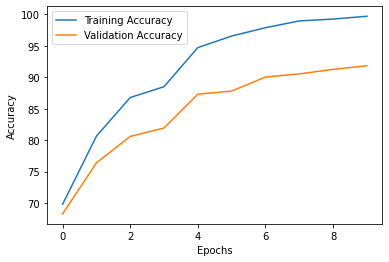

In [35]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

Save Model

In [47]:
torch.save(model.state_dict(), 'model.pth')

Load Model

In [36]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

Audio File Loading and Separation

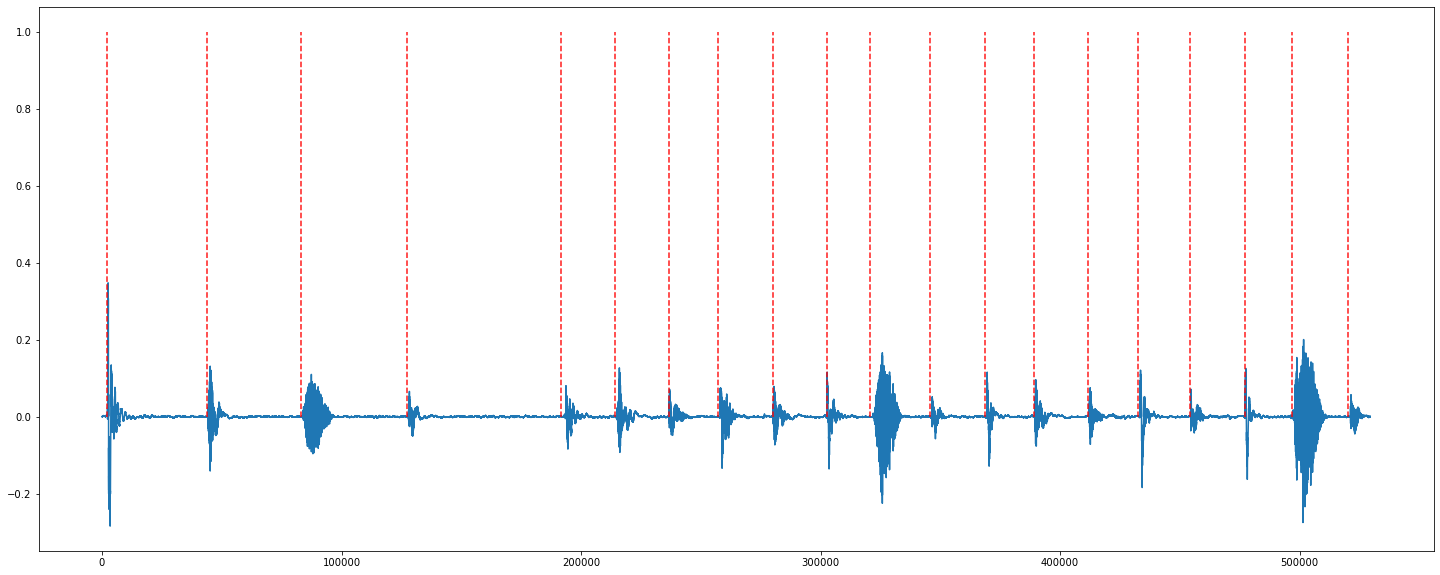

In [56]:
# Load Testing Audio File
beatbox_test, beatbox_sr = librosa.load("joebeatbox.wav", sr = None)

# Detect Onsets
test_onsets = librosa.onset.onset_detect(y = beatbox_test, sr = beatbox_sr, units = 'samples', backtrack = True, normalize = True, delta = .225)

# Plot Onsets
plt.figure(figsize = (25,10))
plt.plot(beatbox_test)
plt.vlines(test_onsets, ymin = 0, ymax = 1,color='r', alpha=0.9,
           linestyle='--', label='Onsets')

In [57]:
# slice audio into individual drum sounds
# Correct Labels
labels = ['k','hhc','hho','s','k','hhc','hhc','k','hhc','k', 'hho','s','k','hhc','hhc','k','s','k', 'hho','s'] # Joe Labels
slices = []
test_dataset = pd.DataFrame(columns = ['Specs','Label'])

for i, onset in enumerate(test_onsets):
    slices.append(beatbox_test[onset : onset+11025])
    
    mel = get_mel_spectrogram(slices[i])
    test_dataset = test_dataset.append({'Specs':mel,'Label':labels[i]}, ignore_index=True)


In [58]:
create_spectrogram_images(test_dataset, 'Joe')

In [59]:
testdata = datasets.ImageFolder(root='./spectrograms/Joe', transform=transforms.ToTensor())
class_map=testdata.class_to_idx
print("\nClass category and index of the images: {}\n".format(class_map))

test_loader = DataLoader(testdata, batch_size=2,num_workers=2, shuffle = True)



Class category and index of the images: {'hhc': 0, 'hho': 1, 'k': 2, 's': 3}



In [66]:
test(test_loader,model,loss_function, device)


Test Error:
acc: 95.0%, avg loss: 0.190205



95.0

In [ ]:
labels = ['k','hhc','hho','s','k','hhc','hho','k','hhc','hho', 's','k','k','hhc','hho','k','hhc','hho', 's','k','k' ] # Noah Labels